In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [3]:
import sncosmo

In [4]:
from lsst.sims.utils import ObservationMetaData
from lsst.sims.catalogs.measures.instance import InstanceCatalog

In [5]:
#The following is to get the object ids in the registry
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


In [6]:
import rates

In [7]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(Om0=0.25, H0=73.)

In [6]:
TwinklesArea = np.radians(1.0/6.)**2 
AreaFactor = np.pi * (np.sqrt(2)*0.4)**2./(1./6.)**2

In [12]:
AreaFactor

36.191147369354432

In [11]:
# Requirement
# There should be 100 SN in the redshift range 0, 0.7 in teh Twinkles area in 1 year (season)

In [12]:
factor = 100./rates.numSN(0., 0.7, 70, cosmo, fieldArea=TwinklesArea, DeltaT=0.5, snrate=rates.snRate).sum();
print factor

131.740349077


In [13]:
binwidth = 0.05
zbins = np.arange(0., 1.2, binwidth);zbins

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15])

In [14]:
zup = np.arange(binwidth, 1.2 + binwidth, binwidth)
zmid = (zbins + zup ) /2.
print len(zbins)

24


In [15]:
# Numbers of Supernova in a circular region of size 0.4 * sqrt(2) in the sprinkled region over 10 years
snnum = factor*rates.numSN(0., 1.2+ binwidth, len(zbins), cosmo, AreaFactor* TwinklesArea, 10, snrate=rates.snRate)

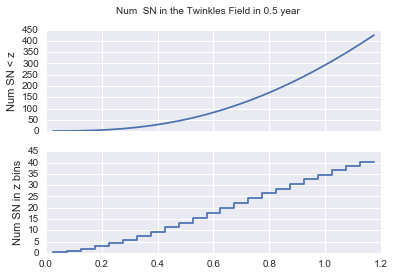

In [16]:
fig, ax = plt.subplots(2,1, sharex=True)
_ = ax[0].plot(zmid, factor*rates.numSN(0., 1.2 + binwidth, len(zbins), cosmo, 
                                 TwinklesArea, 0.5, snrate=rates.snRate).cumsum())

_ = ax[1].step(zmid, factor*rates.numSN(0., 1.2 + binwidth, len(zbins), cosmo, 
                                 TwinklesArea, 0.5, snrate=rates.snRate))
ax[0].set_ylabel('Num SN < z')
ax[1].set_ylabel('Num SN in z bins')
_ = fig.suptitle('Num  SN in the Twinkles Field in 0.5 year')

(array([   1.05412239,    7.30008054,   19.46694017,   37.10801177,
          59.71467839,   86.73952331,  117.61698208,  151.78102231,
         188.67962096,  227.78604028,  268.60708401,  310.68864052,
         353.61889189,  397.02959617,  440.59584396,  484.03466126,
         527.10278679,  569.59390187,  611.33554021,  652.18585626,
         692.03038791,  730.77891228,  768.3624625 ,  804.73054909]),
 array([ 0.        ,  0.04791667,  0.09583333,  0.14375   ,  0.19166667,
         0.23958333,  0.2875    ,  0.33541667,  0.38333333,  0.43125   ,
         0.47916667,  0.52708333,  0.575     ,  0.62291667,  0.67083333,
         0.71875   ,  0.76666667,  0.81458333,  0.8625    ,  0.91041667,
         0.95833333,  1.00625   ,  1.05416667,  1.10208333,  1.15      ]),
 <a list of 1 Patch objects>)

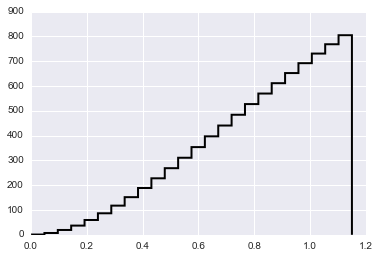

In [17]:
plt.hist(zbins, weights=snnum/AreaFactor, bins=24, histtype='step', alpha=1, lw=2, color='k')

## Get Galaxies on Fatboy

In [7]:
degConv = np.array([1., 1./60., 1./3600.])
raConv = degConv / 24.0 * 360.
centralRA = np.dot(np.array([3., 32., 30]), raConv) #03h 32m 30s
centralDec = np.dot(np.array([-28, 6., 0.]), degConv)
patchRadius = 0.4 * np.sqrt(2)

In [8]:
centralRA

53.125

In [19]:
TwinklesObsMetaData = ObservationMetaData(boundType='circle',pointingRA=centralRA,pointingDec=centralDec,
                                          boundLength=patchRadius, mjd=49540.0)

In [20]:
galaxyTiled  = GalaxyTileObj()

/usr/local/manual/anaconda/lib/python2.7/site-packages/sqlalchemy/dialects/mssql/base.py:1294: SAWarning: Did not recognize type 'geography' of column 'geopoint'
  return fn(*arg, **kw)


In [21]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift', 'a_d', 'b_d', 'pa_disk']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e'}

In [22]:
TwinklesGalaxies = galCopy(galaxyTiled, obs_metadata=TwinklesObsMetaData)

In [ ]:
TwinklesGalaxies.write_catalog('TwinklesGalaxies.dat')

In [23]:
TwinkGalsdf = pd.read_csv('TwinklesGalaxies.dat', sep=',\s+', engine='python', index_col=0)

In [24]:
TwinkGalsdf['zbin'] = TwinkGalsdf.redshift // binwidth

In [25]:
TwinkGalsdf.zbin = TwinkGalsdf.zbin.astype(int)

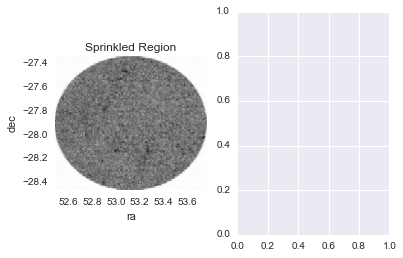

In [50]:
densfig, ax = plt.subplots(1, 2)
ax[0].hexbin(np.degrees(TwinkGalsdf.raJ2000.values), np.degrees(TwinkGalsdf.decJ2000.values))
ax[0].set_aspect('equal')
ax[0].set_ylabel('dec')
ax[0].set_xlabel('ra')
ax[0].set_title('Sprinkled Region')
densfig.savefig('Twinkles_Area.png')

In [29]:
zbinnedGals = TwinkGalsdf.groupby('zbin')

In [30]:
len(snnum), len(zmid)

(24, 24)

In [31]:
zSummary  = pd.DataFrame({'zbin' : np.array(zmid // binwidth, dtype=np.int), 
                          'NumSNperzBin': snnum})

In [32]:
# Astropy cosmology object for CatSim Cosmology
CatSimCosmo = FlatLambdaCDM(Om0=0.25, H0=73.)

alphaTwinkles = 0.11
betaTwinkles = -3.14
cdistTwinkles = [0., 0.1]
x1distTwinkles = [0, 1.]
MTwinkles = [-19.3, 0.15]



In [33]:
def assignIds(snwithHosts, maxval=100):
    snwithHosts['offset'] = 0
    sngroups = snwithHosts.groupby('galtileid')
    for host in (sngroups.count() > 0).index.values:
        sn = sngroups.get_group(host)
        idx  = sn.index
        snwithHosts.loc[idx, 'offset'] = np.arange(len(sn))
    return None

In [34]:
def assignSNHosts(galdf, numSN, seed):
    if seed is not None:
        np.random.seed(seed)
    sngalids = np.random.choice(galdf.index.values, numSN, replace=True)
    zvals = galdf.ix[sngalids,'redshift']
    df = pd.DataFrame({'galtileid': sngalids, 
                      'redshift' : zvals.values})
    return df

In [35]:
# Slow step: Takes about 20 mins
def assignSN(zbinnedGals, SNzSummary, binList=[0, 1], maxval=10, seed=42):
    
    dfs = []
    for idx in binList:
        galdf = zbinnedGals.get_group(idx)
        numSN = SNzSummary.NumSNperzBin[idx]
        if idx == 0 :
            snWithHosts = assignSNHosts(galdf, numSN, seed)
        else:
            snWithHosts = assignSNHosts(galdf, numSN, seed=None)
        assignIds(snWithHosts, maxval=maxval)
        dfs.append(snWithHosts)
    snvals = pd.concat(dfs)
    snvals['snid'] = snvals['galtileid'] *maxval + snvals['offset']
    return snvals

In [36]:
zSummary.zbin.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [38]:
assignStart = time.time()
snvals = assignSN(zbinnedGals, zSummary, binList=zSummary.zbin.values, maxval=100, seed=42)
assignEnd = time.time()

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [39]:
len(snvals)

307900

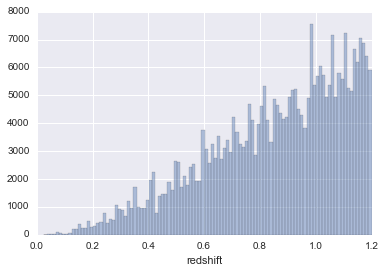

In [40]:
sns.distplot(snvals.redshift, rug=False, kde=False)

In [41]:
snvals.set_index(snvals['snid'], drop=True, verify_integrity=True, inplace=True)

In [42]:
snvals.query('redshift < 0.7').snid.size / 20.

4028.5

In [43]:
def assigSNParams(sntable, seed=42, cosmo=None, T0Min=0., T0Max=3650., 
                  MabsScatter= [-19.3, 0.15], cScatter=[0., 0.1], x1Scatter=[0., 1.], alpha=0.11, beta=-3.14 ):
    if seed is not None:
        np.random.seed(seed)
        
    model = sncosmo.Model(source='salt2')
    if cosmo is None:
        cosmo = FlatLambdaCDM(Om0=0.25, H0=73.)
        
    numSN = len(sntable)
    zvals = sntable.redshift.values
    cvals = np.random.normal(cScatter[0], cScatter[1], size=numSN)
    x1vals = np.random.normal(x1Scatter[0], x1Scatter[1], size=numSN)
    M  = np.random.normal(MabsScatter[0], MabsScatter[1], size=numSN)
    
    M += -alpha * x1vals - beta * cvals 
    t0 = np.random.uniform(T0Min, T0Max, size=numSN)
    x0 = np.zeros(numSN)
    mB = np.zeros(numSN)
    # Slow Step
    for i, Mabs in enumerate(M):
        model.set(z=zvals[i], c=cvals[i], x1=x1vals[i])
        model.set_source_peakabsmag(Mabs, 'bessellB', 'ab', cosmo=cosmo)
        x0[i] = model.get('x0')
        mB[i] = model.source.peakmag('bessellB', 'ab')
    sntable['t0'] = t0
    sntable['c'] = cvals
    sntable['x1'] = x1vals
    sntable['x0'] = x0
    sntable['mB'] = mB
    sntable['M'] = M
    
    print (alpha, beta, cScatter, x1Scatter, MabsScatter)
    

In [45]:

starttime = time.time()
assigSNParams(sntable=snvals, cosmo=CatSimCosmo, alpha=alphaTwinkles, beta=betaTwinkles, MabsScatter=MTwinkles, 
              seed=24)
endtime = time.time()



(0.11, -3.14, [0.0, 0.1], [0.0, 1.0], [-19.3, 0.15])


In [46]:
print endtime - starttime

315.075645924


In [47]:
def assignPositions(sntable, Galsdf, seed=42):

    radiansPerArcSec = (np.pi / 180.)* (1./60.)**2
    if seed is not None:
        np.random.seed(seed)
    
    r1 = np.random.normal(0., 1., sntable.snid.size)
    r2 = np.random.normal(0., 1., sntable.snid.size)
    
    sntable['raJ2000'] = Galsdf.ix[sntable.galtileid, 'raJ2000'].values
    sntable['decJ2000'] = Galsdf.ix[sntable.galtileid, 'decJ2000'].values
    sntable['a_d'] = Galsdf.ix[sntable.galtileid, 'a_d'].values * radiansPerArcSec
    sntable['b_d'] = Galsdf.ix[sntable.galtileid, 'b_d'].values * radiansPerArcSec

    # convert from degrees to radians
    sntable['theta'] = np.radians(Galsdf.ix[sntable.galtileid, 'pa_disk'].values)
    
    sntable['sndec'] = np.cos(-sntable['theta']) * sntable['a_d']* r1 + np.sin(-sntable['theta'])*sntable['b_d'] * r2
    sntable['snra'] =  - np.sin(-sntable['theta']) * sntable['a_d']*r1 + np.cos(-sntable['theta'])* sntable['b_d'] * r2
    sntable['snra'] += Galsdf.ix[sntable.galtileid, 'raJ2000'].values
    sntable['sndec'] += Galsdf.ix[sntable.galtileid, 'decJ2000'].values
    
    sntable['sndec'] = np.degrees(sntable['sndec'])
    sntable['snra'] = np.degrees(sntable['snra'])
    sntable['raJ2000'] = np.degrees(sntable['raJ2000'])
    sntable['decJ2000'] = np.degrees(sntable['decJ2000'])




In [48]:

assignPositions(snvals, TwinkGalsdf, seed=4 )

In [49]:
snvals.head()

,galtileid,redshift,offset,snid,t0,c,x1,x0,mB,M,raJ2000,decJ2000,a_d,b_d,theta,sndec,snra
snid,,,,,,,,,,,,,,,,,
6001014685800,60010146858,0.0452,0,6001014685800,2171.169132,0.132921,0.163237,0.001343,17.677207,-18.743246,53.283190,-27.581455,0.000024,0.000020,1.765229,-27.581426,53.283265
6000001337700,60000013377,0.0376,0,6000001337700,3393.144905,-0.077003,0.121939,0.004584,16.345182,-19.662862,53.471716,-28.124917,0.000013,0.000008,2.615606,-28.124875,53.472507
6000067275900,60000672759,0.0410,0,6000067275900,3106.774493,-0.031628,0.405193,0.002616,16.953475,-19.248227,53.290667,-27.872414,0.000020,0.000017,0.214337,-27.873381,53.289702
6001014687900,60010146879,0.0452,0,6001014687900,2495.557828,-0.099081,-1.440927,0.002169,17.163804,-19.256649,53.737013,-27.971146,0.000024,0.000020,1.765229,-27.973330,53.737539
6000635785100,60006357851,0.0404,0,6000635785100,492.882871,-0.107082,2.146382,0.004358,16.390759,-19.777931,52.967633,-28.024174,0.000019,0.000017,2.232906,-28.023961,52.967234


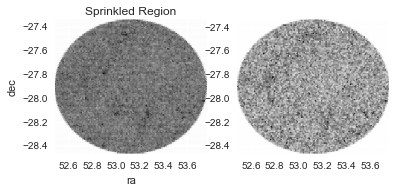

In [56]:
ax[1].hexbin(snvals.snra, snvals.sndec)
ax[1].set_aspect('equal')
densfig

In [ ]:
sns.distplot(snvals.t0)
             

In [63]:
snvals.query('t0 < 50').redshift.size/ AreaFactor

113.53605228552043

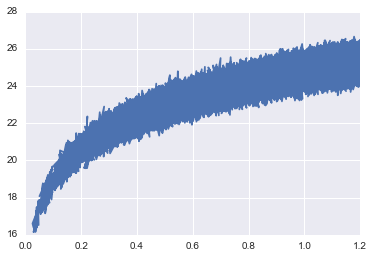

In [64]:
plt.plot(snvals.redshift, snvals.mB)

In [ ]:
snvals.query('redshift < 0.7 and t0 > 570 and t0 < 935').redshift.sum() / AreaFactor

In [ ]:
(snvals.index.values - snvals.galtileid * 100 ).max()

In [ ]:
snvals.head()

In [ ]:
60150 - 59580

In [ ]:
570 + 365


In [ ]:
snvals.to_csv('kraken_sim.csv')

In [ ]:
### OpSim

In [62]:
krakenvisits = pd.read_csv('/Users/rbiswas/doc/projects/LSST/Twinkles/code/SN_sims/SelectedKrakenVisits.csv')

In [13]:
from lsst.sims.photUtils import BandpassDict

In [14]:
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [15]:
from lsst.sims.catUtils.supernovae import SNObject

In [18]:
snobj = SNObject(ra=centralRA, dec=centralDec)

In [78]:
len(snvals)

307900

In [23]:
sntable = pd.read_csv('kraken_sim.csv'); print len(sntable)

307900


In [26]:
Twinkles = sntable.query('snra < 0.116 + @centralRA and snra > -0.116 + @centralRA').query('sndec < 0.116 + @centralDec and sndec > -0.116 + @centralDec')

In [30]:
len(Twinkles.query('redshift < 0.6'))/20.

117.8

In [44]:
from astropy.units import Unit
import os
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


In [45]:
model = sncosmo.Model(source='salt2-extended')

In [50]:
krakenvisits['filter'].values

array(['g', 'i', 'r', ..., 'r', 'y', 'z'], dtype=object)

In [63]:
for index, row in Twinkles.iterrows():
    params = {'c':row['c'], 'x1':row['x1'], 'x0':row['x0'], 't0':row['t0']}
    snid = row['snid']
    model.set(**params)
    krakenvisits['mag_'+str(int(snid))] = model.bandmag(band=krakenvisits['filter'].values, magsys='ab',time=krakenvisits.expMJD)
    #flux = snobj.catsimBandFlux(krakenvisits.expMJD.iloc[0], lsst_bp[krakenvisits['filter'].iloc[0]])
    #err = snobj.catsimBandFluxError(krakenvisits.expMJD.iloc[0], lsst_bp[krakenvisits['filter'].iloc[0]], krakenvisits.fiveSigmaDepth.iloc[0],flux)
    #print flux , err




In [65]:
krakenvisits.to_csv('krakenvists_twinkles.csv')

In [72]:
def func(x):
    x.mean() - x.min()

In [82]:
krakenvisits.groupby('filter').get_group('y')['mag_'].mean() - krakenvisits.groupby('filter').get_group('y')['mag_6000184645801'].min()

7.1054273576010019e-15

In [85]:
Twinkles.set_index('snid', inplace=True)

In [101]:
Twinkles.iloc[0]

galtileid    6.000069e+10
redshift     9.430000e-02
offset       0.000000e+00
snid.1       6.000069e+12
t0           2.204630e+03
c            4.991779e-02
x1          -8.280758e-01
x0           3.471541e-04
mB           1.915094e+01
M           -1.894504e+01
raJ2000      5.308111e+01
decJ2000    -2.786948e+01
a_d          1.115542e-05
b_d          3.669701e-06
theta        5.066478e+00
sndec       -2.786967e+01
snra         5.308083e+01
Name: 6000068561600, dtype: float64

In [87]:
surveyStartDate = 59580

In [91]:
T0Mjd = Twinkles.ix[6000184645801, "t0"] + surveyStartDate; print(T0Mjd)

61582.204722


In [98]:
krakenvisits.query('expMJD < @T0Mjd+70 and expMJD > @T0Mjd-20')['mag_6000184645801']

629    30.092484
Name: mag_6000184645801, dtype: float64

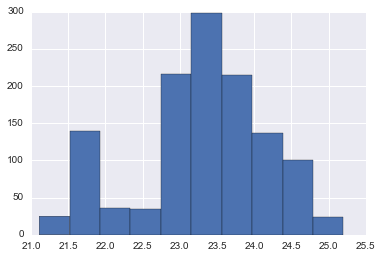

In [107]:
krakenvisits.fiveSigmaDepth.hist()

In [128]:
names = [x for x in krakenvisits.columns if x.startswith('mag_')]
potentialHSNR = [x for x in names if (krakenvisits[x] - krakenvisits['fsD']).min() < 0.]

In [129]:
len(names)

13883

In [130]:
len(potentialHSNR)

1077

In [113]:
krakenvisits.head()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,mag_6000184645801,mag_6000184408901,mag_6000043638100,mag_6001586473901,mag_6000269054205,mag_6001531895002,mag_6000321245000,mag_6001417557202,mag_6000637885901,mag_6000221385203
0,220,1042,152,1427,0.925184,-0.4789,g,11699,59580.135415,0,...,28.266336,27.866121,27.697391,28.145976,28.526304,28.404733,28.418325,28.005642,28.323475,27.438158
1,230,1042,152,1427,0.925184,-0.4789,i,12177,59580.140948,0,...,27.617377,27.784248,27.275260,27.878113,27.823338,28.086856,27.926815,27.864636,27.884126,27.228839
2,200,1042,152,1427,0.925184,-0.4789,r,10861,59580.125716,0,...,27.536583,27.479861,27.140664,27.601803,27.763960,27.868612,27.766292,27.558418,27.694935,27.015630
3,276,1042,152,1427,0.925184,-0.4789,y,14069,59580.162846,0,...,27.297952,27.498321,27.244944,27.282763,27.503450,27.734839,27.486826,27.409329,27.393466,27.239481
4,250,1042,152,1427,0.925184,-0.4789,z,13015,59580.150647,0,...,27.639220,27.791272,27.483809,27.668637,27.848579,28.062127,27.850256,27.750957,27.766323,27.452931


In [112]:
len(potentialHSNR)

12492

In [ ]:
krakenvisits['diffmag'] = krak

In [127]:
krakenvisits['mag_6000184645801'] - krakenvisits['fsD']

obsHistID
220        3.908477
230        4.087858
200        3.301766
276        6.110050
250        4.797234
1637       6.737677
2226       6.864731
2942       6.899515
3665       6.713532
4571       6.800040
185880     3.947187
185900     4.325565
185870     3.376788
185946     5.896694
185926     4.714461
195066     3.841683
195086     4.371412
195056     3.508095
195132     5.887972
195112     4.856091
201057     7.120544
203015     3.384470
203030     3.644025
203005     3.000239
203062     5.321185
203036     4.158300
204764     4.747926
204784     4.512952
204754     3.992537
204830     5.456615
             ...   
2431086    3.907505
2431056    3.025633
2431132    5.338669
2431112    4.288392
2433151    3.491818
2433171    3.742372
2433141    3.073168
2433217    5.400255
2433197    4.274281
2435233    3.832330
2435253    4.060784
2435223    3.398152
2435299    5.711971
2435279    4.587743
2435922    6.764366
2436607    6.526247
2437301    6.811189
2438631    6.732143
2439331   

In [123]:
krakenvisits.set_index('obsHistID', inplace=True)

In [108]:
maxfsd = krakenvisits['mag_6000184645801'].min()

In [114]:
opsimvisits = pd.read_csv('/Users/rbiswas/doc/projects/LSST/Twinkles/code/SN_sims/SelectedKrakenVisits.csv')

In [126]:
krakenvisits['fsD'] = opsimvisits['fiveSigmaDepth']

In [ ]:
krakenvisits

In [118]:
opsimvisits.set_index('obsHistID', inplace=True)

In [119]:
opsimvisits.columns

Index([u'sessionID', u'propID', u'fieldID', u'fieldRA', u'fieldDec', u'filter',
       u'expDate', u'expMJD', u'night', u'visitTime', u'visitExpTime',
       u'finRank', u'FWHMeff', u'FWHMgeom', u'transparency', u'airmass',
       u'vSkyBright', u'filtSkyBrightness', u'rotSkyPos', u'rotTelPos', u'lst',
       u'altitude', u'azimuth', u'dist2Moon', u'solarElong', u'moonRA',
       u'moonDec', u'moonAlt', u'moonAZ', u'moonPhase', u'sunAlt', u'sunAz',
       u'phaseAngle', u'rScatter', u'mieScatter', u'moonIllum', u'moonBright',
       u'darkBright', u'rawSeeing', u'wind', u'humidity', u'slewDist',
       u'slewTime', u'fiveSigmaDepth', u'ditheredRA', u'ditheredDec',
       u'obsID'],
      dtype='object')

In [25]:
3.5 / 30.

0.11666666666666667

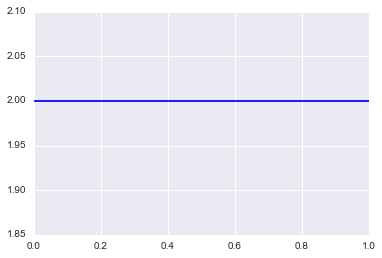

In [8]:
fig, ax = plt.subplots()
ax.axhline(2.)

In [9]:
85450176 / 1e6

85.450176

In [15]:
df = pd.read_csv('galDB.csv')

In [16]:
len(df)

7158432

In [17]:
df.columns

Index([u'id', u'mass_stellar', u'redshift', u'ra', u'dec'], dtype='object')

In [18]:
df['zbin'] = df.redshift // 0.1

In [19]:
grouped = df.groupby('zbin')

In [47]:
dfz = grouped.mass_stellar.agg({'totMass': np.sum}).reset_index()

In [49]:
df.query('zbin==2').mass_stellar.sum()

40228.394024895912

In [48]:
dfz.columns

Index([u'zbin', u'totMass'], dtype='object')

In [50]:
dfz

,zbin,totMass
0,0,1498.733051
1,1,17977.700518
2,2,40228.394025
3,3,62289.793688
4,4,109045.005856
5,5,144177.387569
6,6,181239.424349
7,7,194796.572679
8,8,266515.219771
9,9,302274.588948


In [51]:
joined = pd.merge(df, dfz, how='inner', on='zbin')

In [52]:
joined.head()

,id,mass_stellar,redshift,ra,dec,zbin,totMass
0,2638779,0.055976,0.407043,0.000179,-0.003402,4,109045.005856
1,5796944,0.043954,0.477448,0.000197,-0.010526,4,109045.005856
2,876494,0.137075,0.497270,0.001083,-0.007933,4,109045.005856
3,646728,0.160140,0.407099,0.005305,-0.000600,4,109045.005856
4,196618,1.878882,0.484248,0.002452,-0.004041,4,109045.005856


In [53]:
len(joined) == len(df)

True

In [32]:
df.head()

,id,mass_stellar,redshift,ra,dec,zbin
0,2638779,0.055976,0.407043,0.000179,-0.003402,4
1,326781,0.197341,0.526173,0.004228,-0.000904,5
2,5967705,0.014831,0.707427,0.003078,-0.000042,7
3,5796944,0.043954,0.477448,0.000197,-0.010526,4
4,12792253,0.000018,0.162128,0.000595,-0.009723,1


In [54]:
joined['discreteProb'] = joined['mass_stellar'] / joined['totMass']

In [55]:
joined.columns

Index([u'id', u'mass_stellar', u'redshift', u'ra', u'dec', u'zbin', u'totMass',
       u'discreteProb'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1d12b90d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1d575b690>]], dtype=object)

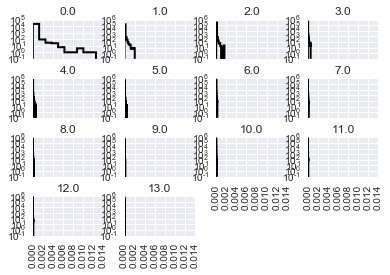

In [66]:
joined.hist('discreteProb', by='zbin', 
            sharex=True,grid=True, **{'log':True, 'histtype':'step', 'alpha':1,
                                     'lw':2, 'color':'k'})

(array([  7.09249700e+06,   5.55190000e+04,   6.33600000e+03,
          2.13300000e+03,   1.03000000e+03,   5.56000000e+02,
          2.88000000e+02,   5.00000000e+00,   2.50000000e+01,
          4.30000000e+01]),
 array([  8.00000009e-07,   6.89491649e+00,   1.37898322e+01,
          2.06847479e+01,   2.75796636e+01,   3.44745793e+01,
          4.13694949e+01,   4.82644106e+01,   5.51593263e+01,
          6.20542420e+01,   6.89491577e+01]),
 <a list of 10 Patch objects>)

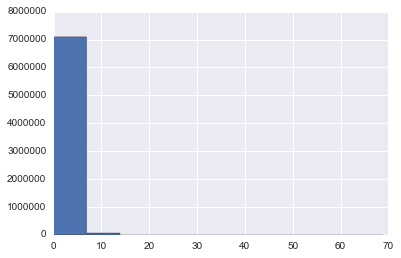

In [67]:
fig, ax = plt.subplots()
ax.hist(joined.mass_stellar)

In [68]:
ax.set_xscale('log')

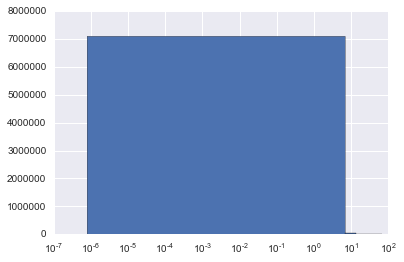

In [69]:
fig

In [73]:
num, bins = np.histogram(joined.mass_stellar)

In [74]:
x = np.histogram(joined.mass_stellar, bins=bins)

In [76]:
x[0] / num[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [77]:
num

array([7092497,   55519,    6336,    2133,    1030,     556,     288,
             5,      25,      43])

In [79]:
x[0]/num

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])